In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re
import numpy as np
import capstone2_utilities as c2 

cores = 4

In [13]:
tweets_with_originals = pd.read_csv('tweets_with_originals.csv', parse_dates = ['tweet_created'])

In [14]:
tweets_with_originals['text_clean'] = tweets_with_originals.text_clean.str.replace(r'@(\w+)([\s.,:;!])?', r'\1 ') # remove @s in @mentions

In [15]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import string
#stopwords = stopwords.union(set([i for i in string.punctuation])) # remove punctuation
#stopwords = stopwords.union(set(['AmericanAir', 'United', 'USAirways', 'JetBlue', 'SouthwestAir', 'Delta', 'VirginAmerica']))

In [16]:
tweets_with_originals.loc[55].text_clean

"VirginAmerica hi! i'm so excited about your $99 LGA-&gt;DAL deal- but i've been trying 2 book since last week &amp; the page never loads. thx!"

# TF-IDF to identify additional stopwords 

Using TF-IDF, we'll look for additional stopwords 

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10)
tweet_input = tweets_with_originals.text_clean
# maybe try to take out numbers, prices 
tweet_input=tweet_input.str.replace(r" (\d|\W)+","") # remove digits, nonword things
T = tfidf_vectorizer.fit_transform(tweet_input) # these are our features

In [18]:
idf_df = pd.DataFrame(index = tfidf_vectorizer.get_feature_names())
idf_df['idf_vals']= tfidf_vectorizer.idf_
idf_df.describe()

,idf_vals
count,1632.000000
mean,7.119166
std,0.957482
min,2.421178
25%,6.609403
50%,7.360819
75%,7.871644
max,8.181799


The minimum inverse document frequency is not so low. For our first pass I won't add any stopwords based on IDF values. 

We can use this array of tfidf vectors as input features... for testing purposes we'll also allow 2-grams and 3-grams to see if this improves the result. 

In [19]:
tf2_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10, ngram_range = (1,2))
tf3_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10, ngram_range = (1,3))
T_2 = tf2_vectorizer.fit_transform(tweet_input) 
T_3 = tf3_vectorizer.fit_transform(tweet_input)

tfidf_input_mats = [T, T_2, T_3]

# Word2Vec Model 

First we'll train a word2vec model on our tweets and see what sorts of words are grouped together. 

In [17]:
from nltk.tokenize.casual import TweetTokenizer
from gensim.models.word2vec import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
cores = 4 # depends on how many cores you have...

tokenizer = TweetTokenizer(preserve_case=False)
tokenized_input = [tokenizer.tokenize(tweet) for tweet in tweet_input.values]
tokenized_input = [[word for word in tweet if word not in string.punctuation] for tweet in tokenized_input]
model_word2vec = Word2Vec(tokenized_input, window=2, min_count=1, workers=cores) # build vocabulary

model_word2vec.train(tokenized_input, total_examples=len(tokenized_input), epochs=10)
model_word2vec.save('airlinetweet_word2vec.model')

The results look ok, airlines are associated with other airlines...

In [21]:
model_word2vec.wv.most_similar('united')

/conda/envs/nlp/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('jetblue', 0.858433187007904),
 ('usairways', 0.7918170690536499),
 ('americanair', 0.786402702331543),
 ('southwestair', 0.7863386273384094),
 ('virginamerica', 0.634326696395874),
 ('guess', 0.5249053239822388),
 ('certainly', 0.5245820879936218),
 ('but', 0.5198203325271606),
 ('haha', 0.46811652183532715),
 ('fine', 0.467410683631897)]

In [22]:
model_word2vec.wv.most_similar('usairways')

[('americanair', 0.8042764663696289),
 ('united', 0.7918170690536499),
 ('southwestair', 0.7464061975479126),
 ('jetblue', 0.7016778588294983),
 ('virginamerica', 0.4542508125305176),
 ('certainly', 0.4246622323989868),
 ('happened', 0.41901466250419617),
 ('idea', 0.414933979511261),
 ('mind', 0.41486549377441406),
 ('know', 0.41471704840660095)]

And TSA with security check type things

In [23]:
model_word2vec.wv.most_similar('tsa')

[('pre', 0.8031080961227417),
 ('file', 0.7105032801628113),
 ('receipt', 0.7090972661972046),
 ('number', 0.7015888690948486),
 ('name', 0.6989423036575317),
 ('res', 0.6933581829071045),
 ('reservation', 0.684999406337738),
 ('itinerary', 0.6801326870918274),
 ('request', 0.675376832485199),
 ('husband', 0.6723905801773071)]

Let's test a few models. 

In [46]:
alpha = [.01, .075, .05, .025]
window = [1,2,3]
word2vec_models = []
for a in alpha:
    for ws in window:
        model_word2vec = Word2Vec(tokenized_input, window=ws, alpha = a, min_count=1, workers=cores) # build vocabulary
        model_word2vec.train(tokenized_input, total_examples=len(tokenized_input), epochs=50)
        word2vec_models.append(model_word2vec)

## Doc2Vec Model

Doc2Vec learns "document" vectors instead of word vectors. We view each tweet as a document

In [18]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
sentiment_tweets_docs = [TaggedDocument(tokenized_input[i], [str(tweets_with_originals.tweet_id.iloc[i])]) for i in range(tweet_input.shape[0])]

In [19]:
vector_size = [50,100,150]
window = [1,2,3]
alg_type = [0, 1] # 0 corresponds to PV-DBOW, 1 to PV-DM

doc2vec_models = [] 
for vs in vector_size:
    for w in window: 
        for d in alg_type:
            model_doc2vec = Doc2Vec(dm=d, vector_size=vs, hs=1, window=w,
                        min_count=1, sample=0, epochs=100, 
                        workers=cores, dbow_words = 0)
            model_doc2vec.build_vocab(sentiment_tweets_docs)
            model_doc2vec.train(sentiment_tweets_docs, total_examples = len(sentiment_tweets_docs), epochs=model_doc2vec.epochs)
            doc2vec_models.append(model_doc2vec)

In [21]:
import pickle
pickle.dump(doc2vec_models, open( "word2vec_sow_inputs.pkl", "wb" ) )

We'll evaluate these models when we get to the logistic regression/ random forest part of the sentiment analysis. 

# Sentiment Analysis

The sentiments in our dataset are highly imbalanced: 

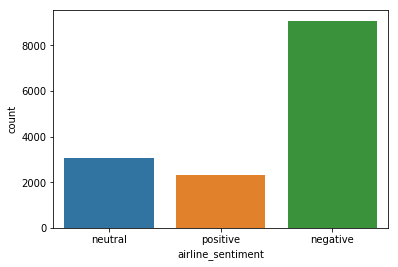

In [26]:
_ = sns.countplot(x = 'airline_sentiment', data = tweets_with_originals)

There are a lot of strategies we could try to rebalance the dataset. The easiest would be oversampling the neutral/positive sentiment tweets. 

In [47]:
# test split with oversampling ... try SMOTE 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
y = tweets_with_originals.airline_sentiment.map({'negative': 0, 'neutral':1, 'positive':2})

# test_train split for TFIDF outputs 
tfidf_learning_inputs = []
for M in tfidf_input_mats:
    T_train, T_test, y_train, y_test = train_test_split(T, y, test_size=0.3)
    sm = SMOTE() # smarter upsampling 
    T_train_sm, y_train_sm = sm.fit_sample(T_train, y_train.ravel())
    tfidf_learning_inputs.append([T_train_sm, T_test, y_train_sm, y_test])

In [27]:
# test_train_split for Doc2Vec outputs
#train
tweet_ids = tweets_with_originals.tweet_id.astype(str).values
doc2vec_learning_inputs = []
for model in doc2vec_models: 
    X_train, X_test, y_train, y_test = c2.doc2vec_train_test_split(model, tweet_ids, y)
    sm = SMOTE()
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
    doc2vec_learning_inputs.append([X_train_sm, X_test, y_train_sm, y_test])

We confirm that SMOTE balances the number of training samples in each class... 

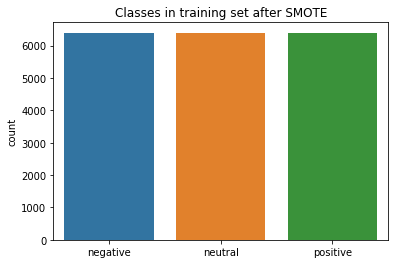

In [49]:
_ = sns.countplot(x = tfidf_learning_inputs[0][2])
_ = plt.title('Classes in training set after SMOTE')
locs, labels = plt.xticks()
_ = plt.xticks(locs, ['negative', 'neutral', 'positive'], )

## Method 1: Logistic Regression

### TF-IDF input sentiment analysis
Basic logistic regression with one-versus-rest (OVR) multiclass scheme. 

In [50]:
from sklearn.linear_model import LogisticRegression

tfidf_log_models = []
for i, ngram_model in enumerate(tfidf_learning_inputs): 
    lr = LogisticRegression(solver = 'saga', multi_class='multinomial', max_iter = 200)
    lr.fit(ngram_model[0], ngram_model[2])
    print('{}-gram TF-IDF:\t Train Accuracy {}'.format(i+1,lr.score(ngram_model[0], ngram_model[2])))
    print('{}-gram TF-IDF:\t Test Accuracy {}'.format(i+1,lr.score(ngram_model[1], ngram_model[3])))
    tfidf_log_models.append(lr)

1-gram TF-IDF:	 Train Accuracy 0.8450520833333334
1-gram TF-IDF:	 Test Accuracy 0.7438378253858557
2-gram TF-IDF:	 Train Accuracy 0.8386255800615257
2-gram TF-IDF:	 Test Accuracy 0.7413038470398525
3-gram TF-IDF:	 Train Accuracy 0.8447172384849438
3-gram TF-IDF:	 Test Accuracy 0.7442985487214927


### Word2Vec input sentiment analysis

We try the sum of words embedding which is described [here](https://white.ucc.asn.au/publications/White2015SentVecMeaning.pdf). We just take the sum of the word vectors contained in a tweet. 

In [51]:
target_vec = tweets_with_originals.set_index('tweet_id').airline_sentiment.map({'negative': 0, 'neutral':1, 'positive':2})
tokenized_input_ser = pd.Series(tokenized_input, index=tweets_with_originals.tweet_id)

In [52]:
word2vec_sow_inputs = []
for model in word2vec_models:
    X_train, X_test, y_train, y_test = c2.word2vec_train_test_split(model_word2vec, tokenized_input_ser, target_vec)
    sm = SMOTE() # smarter upsampling 
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
    word2vec_sow_inputs.append([X_train_sm, X_test, y_train_sm, y_test])

In [53]:
word2vec_avg_inputs = []
for model in word2vec_models:
    X_train, X_test, y_train, y_test = c2.word2vec_train_test_split(model_word2vec, tokenized_input_ser, target_vec, embedding = 'avge')
    sm = SMOTE() # smarter upsampling 
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
    word2vec_avg_inputs.append([X_train_sm, X_test, y_train_sm, y_test])

### Word2vec Sum of words input sentiment analysis 

In [54]:
word2vec_sow_log_models = []
for i, sow_model in enumerate(word2vec_sow_inputs): 
    lr = LogisticRegression(solver = 'lbfgs', multi_class='auto', max_iter = 2000)
    lr.fit(sow_model[0], sow_model[2])
    print('Word2Vec Sum of words Model {}:\t Accuracy {}'.format(i+1,lr.score(sow_model[1], sow_model[3])))
    word2vec_sow_log_models.append(lr)

Word2Vec Sum of words Model 1:	 Accuracy 0.7069799585348998
Word2Vec Sum of words Model 2:	 Accuracy 0.7115871918912693
Word2Vec Sum of words Model 3:	 Accuracy 0.7108961068878139
Word2Vec Sum of words Model 4:	 Accuracy 0.7157337019120018
Word2Vec Sum of words Model 5:	 Accuracy 0.7161944252476388
Word2Vec Sum of words Model 6:	 Accuracy 0.7168855102510943
Word2Vec Sum of words Model 7:	 Accuracy 0.7067495968670813
Word2Vec Sum of words Model 8:	 Accuracy 0.7026030868463488
Word2Vec Sum of words Model 9:	 Accuracy 0.7108961068878139
Word2Vec Sum of words Model 10:	 Accuracy 0.7145818935729095
Word2Vec Sum of words Model 11:	 Accuracy 0.7173462335867312
Word2Vec Sum of words Model 12:	 Accuracy 0.7145818935729095


### Word2vec Avg embedding input sentiment analysis

In [55]:
word2vec_avg_log_models = []
for i, avg_model in enumerate(word2vec_avg_inputs): 
    lr = LogisticRegression(solver = 'lbfgs', multi_class='auto', max_iter = 2000)
    lr.fit(avg_model[0], avg_model[2])
    print('Word2Vec Mean Embedding Model {}:\t Accuracy {}'.format(i+1,lr.score(avg_model[1], avg_model[3])))
    word2vec_avg_log_models.append(lr)

Word2Vec Mean Embedding Model 1:	 Accuracy 0.7127390002303616
Word2Vec Mean Embedding Model 2:	 Accuracy 0.7092835752130845
Word2Vec Mean Embedding Model 3:	 Accuracy 0.7228749136143746
Word2Vec Mean Embedding Model 4:	 Accuracy 0.7251785302925593
Word2Vec Mean Embedding Model 5:	 Accuracy 0.7088228518774476
Word2Vec Mean Embedding Model 6:	 Accuracy 0.7198802119327344
Word2Vec Mean Embedding Model 7:	 Accuracy 0.7201105736005529
Word2Vec Mean Embedding Model 8:	 Accuracy 0.714351531905091
Word2Vec Mean Embedding Model 9:	 Accuracy 0.7164247869154573
Word2Vec Mean Embedding Model 10:	 Accuracy 0.7194194885970975
Word2Vec Mean Embedding Model 11:	 Accuracy 0.7228749136143746
Word2Vec Mean Embedding Model 12:	 Accuracy 0.7120479152269062


Average and sum of word embeddings for tweets seem to perform comparably: this is in line with what we'd expect from the literature. 

### Doc2Vec input sentiment analysis

In [30]:
doc2vec_log_models = []
for i,model in enumerate(doc2vec_learning_inputs): 
    lr = LogisticRegression(solver='saga', multi_class = 'multinomial', max_iter = 2000)
    lr.fit(model[0], model[2])
    print('Model {}: \t Accuracy {}'.format(i+1, lr.score(model[1], model[3])))
    doc2vec_log_models.append(lr)

Model 1: 	 Accuracy 0.6268140981340705
Model 2: 	 Accuracy 0.5381248560239577
Model 3: 	 Accuracy 0.6242801197880673
Model 4: 	 Accuracy 0.5401981110343239
Model 5: 	 Accuracy 0.6185210780926054
Model 6: 	 Accuracy 0.5560930661137987
Model 7: 	 Accuracy 0.6749596867081318
Model 8: 	 Accuracy 0.5816632112416494
Model 9: 	 Accuracy 0.6685095600092145
Model 10: 	 Accuracy 0.6053904630269523
Model 11: 	 Accuracy 0.6763418567150427
Model 12: 	 Accuracy 0.6164478230822391
Model 13: 	 Accuracy 0.6821008984105045
Model 14: 	 Accuracy 0.585348997926745
Model 15: 	 Accuracy 0.6952315134761575
Model 16: 	 Accuracy 0.6120709513936881
Model 17: 	 Accuracy 0.7037548951854411
Model 18: 	 Accuracy 0.6288873531444368


Performance is poor here: instability was observed in results when training the various Doc2Vec models. I think that we need more training data: the number of tweets we have is pretty low for the complexity of the doc2vec NN. 

## Method 2: Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
tfidf_rf_models = []
for i, ngram_model in enumerate(tfidf_learning_inputs): 
    rf = RandomForestClassifier(n_estimators = 200, criterion = 'gini', max_features = 'sqrt', max_depth = 20)
    rf.fit(ngram_model[0], ngram_model[2])
    print('{}-gram TF-IDF:\t Accuracy {}'.format(i+1,rf.score(ngram_model[1], ngram_model[3])))
    tfidf_rf_models.append(rf)

1-gram TF-IDF:	 Accuracy 0.7053674268601705
2-gram TF-IDF:	 Accuracy 0.7009905551716195
3-gram TF-IDF:	 Accuracy 0.6975351301543423


In [68]:
word2vec_sow_rf_models = []
for i, model in enumerate(word2vec_sow_inputs): 
    rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_features = 'sqrt', max_depth = 10)
    rf.fit(model[0], model[2])
    print('Model {}: \t Accuracy {}'.format(i+1,rf.score(model[1], model[3])))
    word2vec_sow_rf_models.append(rf)

Model 1: 	 Accuracy 0.7254088919603778
Model 2: 	 Accuracy 0.7228749136143746
Model 3: 	 Accuracy 0.7217231052752822
Model 4: 	 Accuracy 0.7166551485832757
Model 5: 	 Accuracy 0.7297857636489288
Model 6: 	 Accuracy 0.7254088919603778
Model 7: 	 Accuracy 0.7242570836212854
Model 8: 	 Accuracy 0.7272517853029256
Model 9: 	 Accuracy 0.7224141902787377
Model 10: 	 Accuracy 0.7247178069569223
Model 11: 	 Accuracy 0.7364662520156646
Model 12: 	 Accuracy 0.7161944252476388


In [69]:
word2vec_avg_rf_models = []
for i, model in enumerate(word2vec_avg_inputs): 
    rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_features = 'sqrt', max_depth = 10)
    rf.fit(model[0], model[2])
    print('Model {}: \t Accuracy {}'.format(i+1,rf.score(model[1], model[3])))
    word2vec_avg_rf_models.append(rf)

Model 1: 	 Accuracy 0.7150426169085464
Model 2: 	 Accuracy 0.7168855102510943
Model 3: 	 Accuracy 0.7362358903478461
Model 4: 	 Accuracy 0.7313982953236582
Model 5: 	 Accuracy 0.7228749136143746
Model 6: 	 Accuracy 0.7307072103202027
Model 7: 	 Accuracy 0.7212623819396452
Model 8: 	 Accuracy 0.7184980419258236
Model 9: 	 Accuracy 0.718267680258005
Model 10: 	 Accuracy 0.7242570836212854
Model 11: 	 Accuracy 0.7332411886662059
Model 12: 	 Accuracy 0.7122782768947247


In [31]:
doc2vec_rf_models = []
for i, model in enumerate(doc2vec_learning_inputs): 
    rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_features = 'sqrt', max_depth = 10)
    rf.fit(model[0], model[2])
    print('Model {}: \t Accuracy {}'.format(i+1,rf.score(model[1], model[3])))
    doc2vec_rf_models.append(rf)

Model 1: 	 Accuracy 0.6763418567150427
Model 2: 	 Accuracy 0.6457037548951854
Model 3: 	 Accuracy 0.6657452199953927
Model 4: 	 Accuracy 0.6387929048606312
Model 5: 	 Accuracy 0.6839437917530523
Model 6: 	 Accuracy 0.6491591799124625
Model 7: 	 Accuracy 0.7134300852338171
Model 8: 	 Accuracy 0.6680488366735775
Model 9: 	 Accuracy 0.7062888735314443
Model 10: 	 Accuracy 0.6673577516701221
Model 11: 	 Accuracy 0.714351531905091
Model 12: 	 Accuracy 0.663441603317208
Model 13: 	 Accuracy 0.7115871918912693
Model 14: 	 Accuracy 0.6701220916839438
Model 15: 	 Accuracy 0.7102050218843584
Model 16: 	 Accuracy 0.6668970283344852
Model 17: 	 Accuracy 0.7191891269292789
Model 18: 	 Accuracy 0.677954388389772


In [32]:
for idx, model in enumerate(doc2vec_models):
    model.save('doc2vec_{}.model'.format(idx))
for idx, model in enumerate(word2vec_models):
    model.save('word2vec_{}.model'.format(idx))

### Hyperparameter Tuning for RandomForestClassifier

In [4]:
# With thanks to towardsdatascience: 
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestClassifier(bootstrap=False)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

# Fit the random search model
rf_random.fit(word2vec_sow_inputs[10][0], word2vec_sow_inputs[10][2])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 61.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 225.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 435.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [5]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90}

In [8]:
print(word2vec_sow_models[10].alpha_)

In [11]:
model=word2vec_sow_inputs[10]
rf = RandomForestClassifier(n_estimators = 1800, criterion = 'gini', max_features = 'auto', max_depth = 90, 
                               min_samples_split=2, min_samples_leaf = 1)
rf.fit(model[0], model[2])
print('Model {}: \t Accuracy {}'.format(11,rf.score(model[1], model[3])))


Model 11: 	 Accuracy 0.7542041004376872


In [33]:
model=doc2vec_learning_inputs[16]
rf = RandomForestClassifier(n_estimators = 1800, criterion = 'gini', max_features = 'auto', max_depth = 90, 
                               min_samples_split=2, min_samples_leaf = 1)
rf.fit(model[0], model[2])
print('Model {}: \t Accuracy {}'.format(11,rf.score(model[1], model[3])))

Model 11: 	 Accuracy 0.7233356369500116
